In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

/usr/local/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


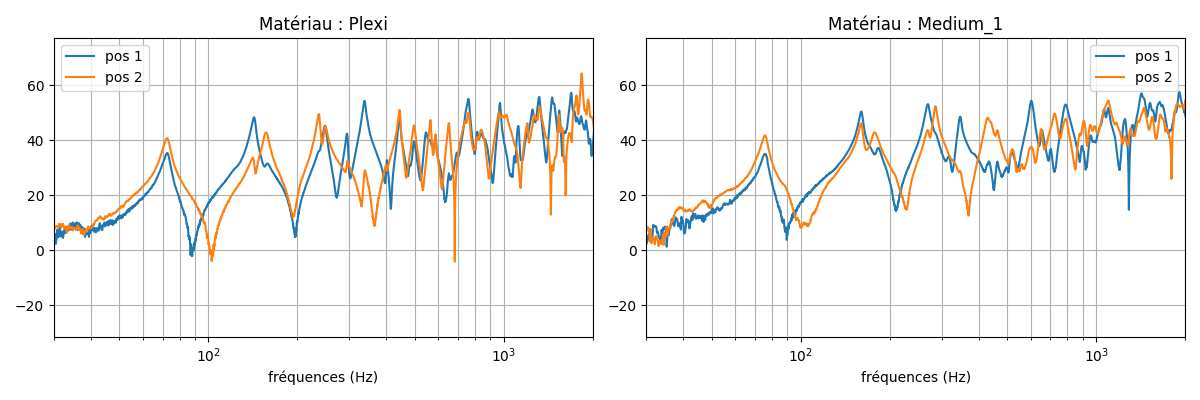

In [2]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogx(deforme_Nta_Npos[2,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[2,0]["FRF"])),label="pos 1")
ax1.semilogx(deforme_Nta_Npos[2,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[2,1]["FRF"])),label="pos 2")
ax1.grid(which="both")
ax1.set_title(f"Matériau : {deforme_Nta_Npos[2,0]['mat_table']}")
ax1.set_ylabel("")
ax1.set_xlabel("fréquences (Hz)")
ax1.legend()
ax1.set_xlim(30,2000)
ylims = ax1.set_ylim()

ax2.semilogx(deforme_Nta_Npos[1,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[1,0]["FRF"])),label="pos 1")
ax2.semilogx(deforme_Nta_Npos[1,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[1,1]["FRF"])),label="pos 2")
ax2.grid(which="both")
ax2.set_title(f"Matériau : {deforme_Nta_Npos[1,0]['mat_table']}")
ax2.set_ylabel("")
ax2.set_xlabel("fréquences (Hz)")
ax2.legend()
ax2.set_xlim(30,2000)
ax2.set_ylim(ylims)

fig.tight_layout()

plt.show()

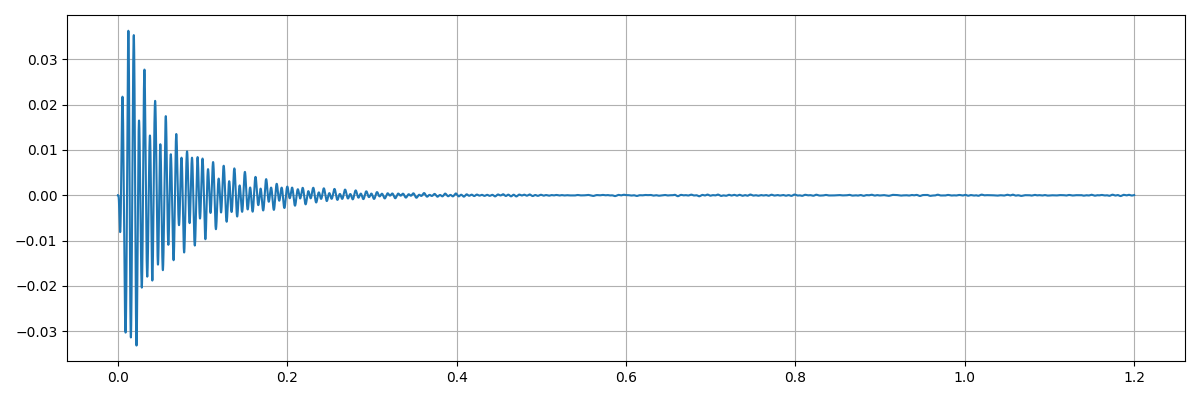

In [46]:
idx_mat = 1

RI = deforme_Nta_Npos[idx_mat, 0]["RI"]
fs = deforme_Nta_Npos[idx_mat, 0]["fs"]
tRI = np.arange(len(RI))/fs


tRI, RI = mm.clean_RI(RI, fs, method="max", cut_end=1.2)

RI_filtered = mm.bandpass_filter(RI,30, 150, fs, order=20)

fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.plot(tRI,RI,label="")
ax1.plot(mm.time_vector(RI_filtered,fs),RI_filtered,label="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [47]:
fk, deltak = mm.ESPRIT(RI_filtered[:512*7], 512*7//2, 100, return_pos=True)

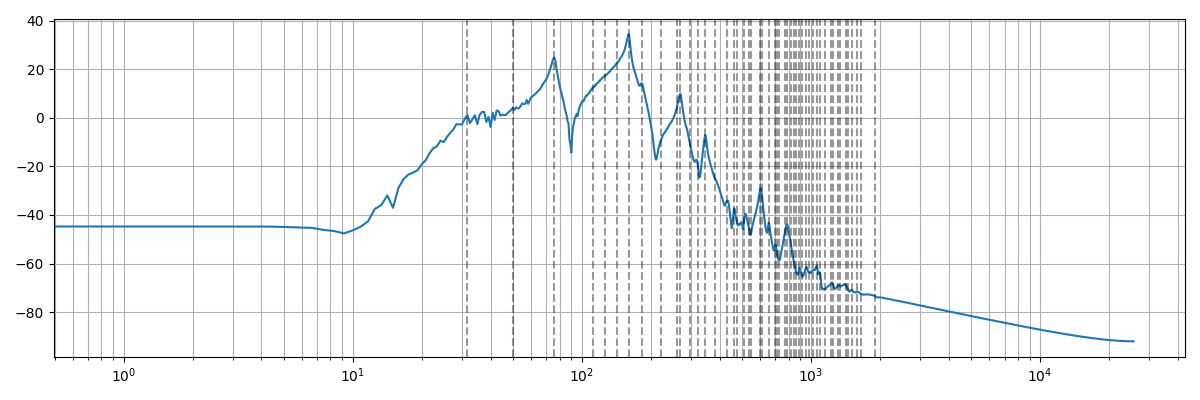

In [48]:
Y = np.fft.rfft(RI_filtered)
fy = np.fft.rfftfreq(len(RI_filtered),1/fs)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
ax1.grid(which="both")
#ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ylims = ax1.set_ylim()
ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

fig.tight_layout()

plt.show()

In [49]:
amp = np.zeros(len(fk))
for i in range(len(fk)) :
    fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
    amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
fk[amp.argsort()[-4:][::-1]]*fs

array([159.96396368,  75.3970854 , 143.06267626, 126.51195943])

In [19]:
fk*fs

array([  30.09566112,   31.81545977,   52.20537897,   75.43560674,
         96.38949577,  126.71179603,  141.94719951,  159.86406601,
        185.4607338 ,  187.5591737 ,  239.15770037,  268.82181835,
        288.3644696 ,  316.67311329,  344.31293409,  346.71508778,
        381.23283152,  421.83888031,  423.56922099,  432.58023722,
        461.0520304 ,  506.34526116,  514.91377632,  539.83137563,
        578.27843976,  602.9164318 ,  616.14755273,  654.02802281,
        682.84011997,  701.25656776,  734.86259562,  784.68223302,
        796.02701424,  809.61260722,  852.08997323,  889.90924634,
        908.44350331,  957.85804719,  978.98357145, 1011.36065099,
       1015.36044457, 1062.74338851, 1096.83622418, 1143.48355445,
       1246.21383964, 1317.69281309, 1418.4421107 , 1499.36405549,
       1610.03931757, 1870.83312467])

In [20]:
ak, _ = mm.LeastSquares(RI_filtered, deltak, fk)

In [21]:
20*np.log10(np.abs(ak))

/var/folders/9z/kzhjdk9j47z0026s88r_0ssh0000gn/T/ipykernel_76648/2875441743.py:1: RuntimeWarning: divide by zero encountered in log10
  20*np.log10(np.abs(ak))


array([[-1816.17782835],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
       [          -inf],
